## Covering Canadian Traveller — Analysis Notebook
 Student 1 : OZGENC Doruk [21113927]<br>
 Student 2 : MAMLOUK Haya [21107689]<br>
 <br>
 This notebook loads the `results.csv` produced by `experiments.py`and visualises **competitive ratio** and **running time** across instance sizes *n* numbers of blocked edges *k*, and the two algorithms (CR vs CNN).

 Competitive ratio values bellow 1 are due to rounding error while working with floaters and should be considered as 1. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("results.csv")
df.head()

,family,n,k,seed,algo,tour_len,offline_opt_lb,competitive_ratio,time_ms,status
0,B,20,0,0,CR,3.26034,3.26034,1.0,92,OK
1,B,20,0,0,CNN,3.26034,3.26034,1.0,2,OK
2,B,20,1,0,CR,3.26034,3.26034,1.0,90,OK
3,B,20,1,0,CNN,3.26034,3.26034,1.0,2,OK
4,B,20,1,0,CR,3.26034,3.26034,1.0,91,OK


### Helper: derive *k/n* (share of blocked edges) for nicer grouping

In [5]:
df["k_fraction"] = df["k"] / df["n"]
df["k_fraction_lbl"] = df["k_fraction"].map(lambda x: f"{x:.2f}")

## 1 Competitive‑ratio distribution by *n* (boxplots)  

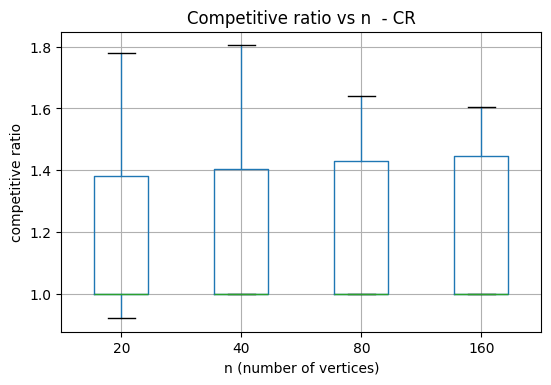

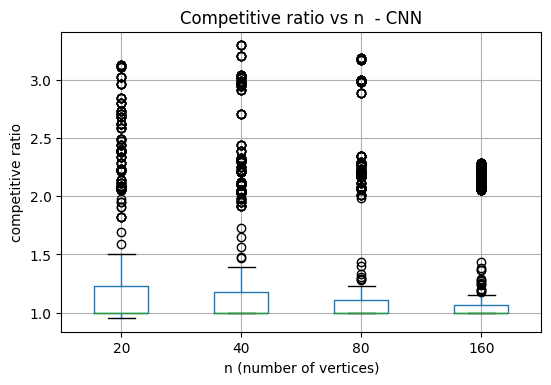

In [6]:
for algo in df["algo"].unique():
    subset = df[df["algo"] == algo]
    fig, ax = plt.subplots(figsize=(6, 4))
    subset.boxplot(column="competitive_ratio", by="n", ax=ax)
    ax.set_title(f"Competitive ratio vs n  - {algo}")
    ax.set_xlabel("n (number of vertices)")
    ax.set_ylabel("competitive ratio")
    plt.suptitle("")   # kill the automatic title Matplotlib adds
    plt.show()

## 2 Average competitive ratio — heat‑map *n × k* (per algorithm)

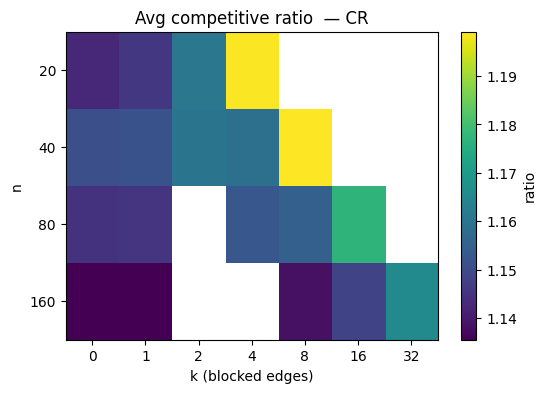

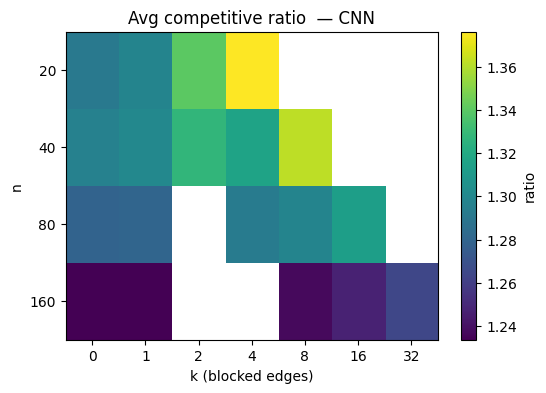

In [7]:
pivoted = (
    df.groupby(["algo", "n", "k"])["competitive_ratio"]
      .mean()
      .reset_index()
)
for algo in df["algo"].unique():
    table = pivoted[pivoted["algo"] == algo].pivot(index="n", columns="k", values="competitive_ratio")
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(table, aspect="auto")
    ax.set_xticks(range(len(table.columns)), table.columns)
    ax.set_yticks(range(len(table.index)), table.index)
    ax.set_xlabel("k (blocked edges)")
    ax.set_ylabel("n")
    ax.set_title(f"Avg competitive ratio  — {algo}")
    fig.colorbar(im, ax=ax, label="ratio")
    plt.show()


## 3 Running‑time vs *n* (log–log line plot)

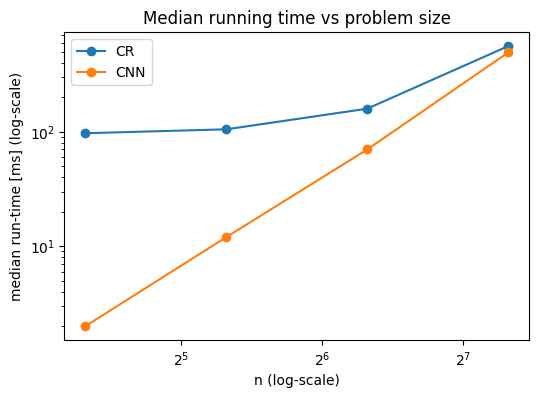

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
for algo in df["algo"].unique():
    grp = df[df["algo"] == algo].groupby("n")["time_ms"].median().sort_index()
    ax.plot(grp.index, grp.values, marker="o", label=algo)
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("n (log-scale)")
ax.set_ylabel("median run-time [ms] (log-scale)")
ax.set_title("Median running time vs problem size")
ax.legend()
plt.show()

## 4 Scatter: tour length vs Christofides lower bound  
(should sit above the diagonal; any point *below* is due to rounding errors)

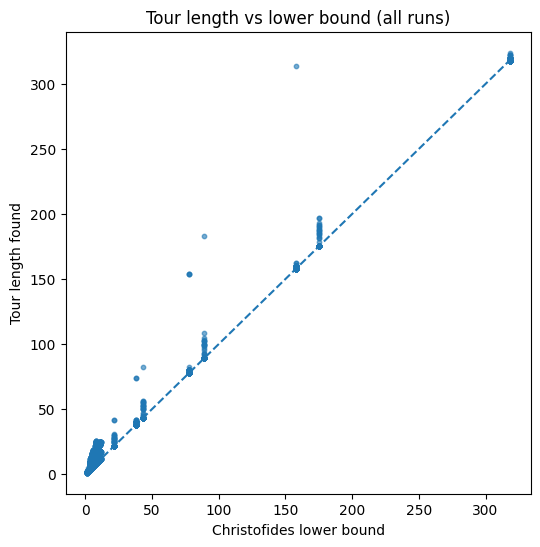

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df["offline_opt_lb"], df["tour_len"], s=10, alpha=0.6)
ax.plot([df["offline_opt_lb"].min(), df["offline_opt_lb"].max()],
        [df["offline_opt_lb"].min(), df["offline_opt_lb"].max()],
        linestyle="--")
ax.set_xlabel("Christofides lower bound")
ax.set_ylabel("Tour length found")
ax.set_title("Tour length vs lower bound (all runs)")
plt.show()

## 5 Histogram of competitive ratios (all runs, stacked by algorithm)

(Only includes the ratios greater than 1)

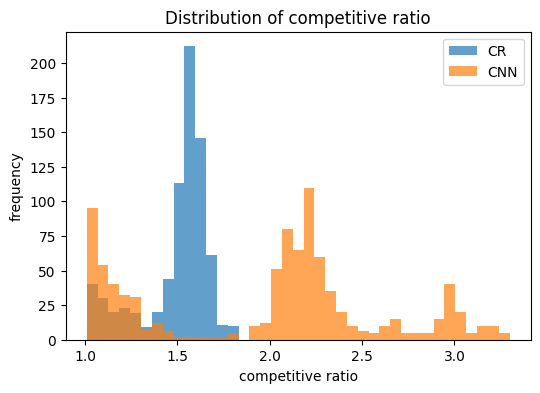

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
bins = np.linspace(1.01, df["competitive_ratio"].max(), 40)
for algo in df["algo"].unique():
    ax.hist(df[df["algo"] == algo]["competitive_ratio"],
            bins=bins,
            alpha=0.7,
            label=algo)
ax.set_xlabel("competitive ratio")
ax.set_ylabel("frequency")
ax.set_title("Distribution of competitive ratio")
ax.legend()
plt.show()

## 6 Timeout / error overview 

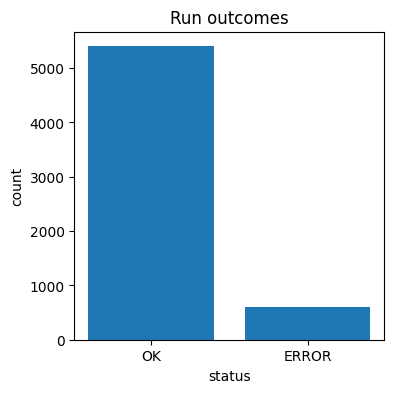

In [11]:
if "status" in df.columns:
    counts = df["status"].value_counts()
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_xlabel("status")
    ax.set_ylabel("count")
    ax.set_title("Run outcomes")
    plt.show()

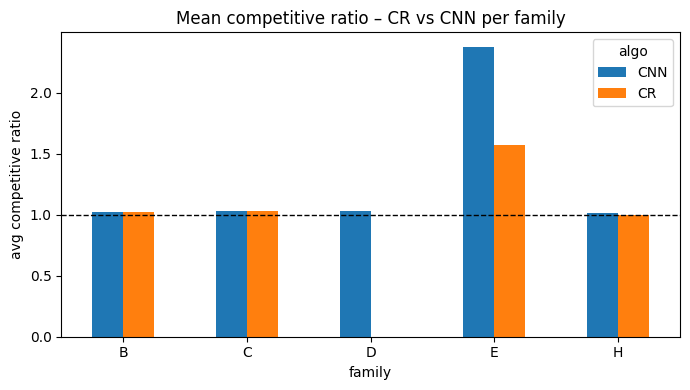

In [12]:
avg_cr = (
    df[df["status"] == "OK"]
      .groupby(["family", "algo"])["competitive_ratio"]
      .mean()
      .unstack()
      .sort_index()
)

avg_cr.plot(kind="bar", figsize=(7,4), rot=0, ylabel="avg competitive ratio",
            title="Mean competitive ratio – CR vs CNN per family")
plt.axhline(1, color="k", lw=1, ls="--")          # offline optimum
plt.tight_layout()


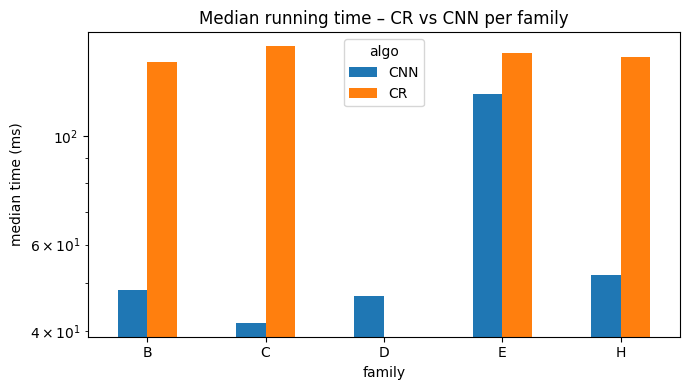

In [13]:
med_rt = (
    df[df["status"] == "OK"]
      .groupby(["family", "algo"])["time_ms"]
      .median()
      .unstack()
      .sort_index()
)

med_rt.plot(kind="bar", figsize=(7,4), rot=0, ylabel="median time (ms)",
            title="Median running time – CR vs CNN per family", logy=True)
plt.tight_layout()


/var/folders/hc/qdslg8y5157drydftw3xn2f00000gn/T/ipykernel_2223/3365441749.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  plt.imshow(winner.applymap(lambda x: 1 if x=="CR better" else 0),


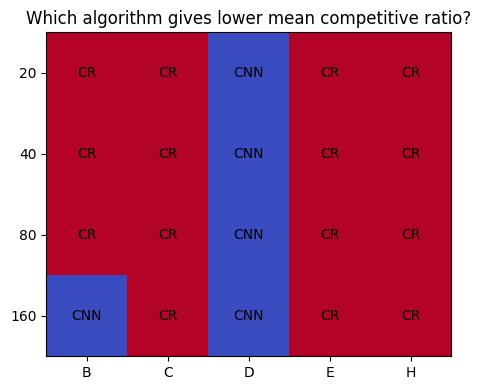

In [14]:
# pivot to rows: family,size | cols: algo → mean CR
pivot = (df[df["status"]=="OK"]
           .groupby(["family","n","algo"])["competitive_ratio"]
           .mean()
           .unstack())

winner = (pivot["CR"] < pivot["CNN"]).map({True:"CR better", False:"CNN better"})
winner = winner.unstack(level=0)   # rows size, cols family

plt.figure(figsize=(6,4))
plt.imshow(winner.applymap(lambda x: 1 if x=="CR better" else 0),
           cmap="coolwarm", vmin=0, vmax=1)
plt.xticks(range(len(winner.columns)), winner.columns)
plt.yticks(range(len(winner.index)),   winner.index)
for i,size in enumerate(winner.index):
    for j,fam in enumerate(winner.columns):
        plt.text(j,i,"CR" if winner.loc[size,fam]=="CR better" else "CNN",
                 ha="center",va="center",color="black")
plt.title("Which algorithm gives lower mean competitive ratio?")
plt.tight_layout()


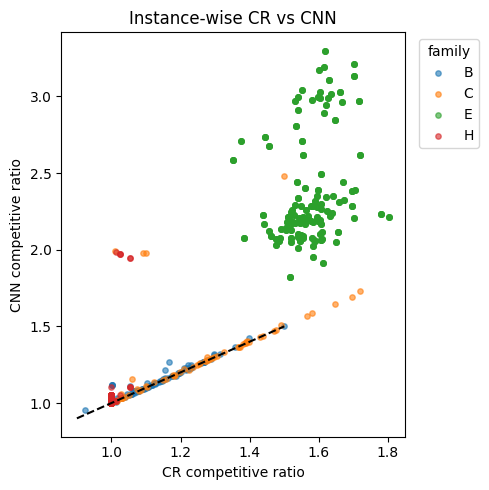

In [15]:
sub = df[(df["status"]=="OK") & (df["algo"]=="CR")][
          ["family","n","k","seed","competitive_ratio"]].rename(
          columns={"competitive_ratio":"cr_ratio"})
sub = sub.merge(
        df[(df["status"]=="OK") & (df["algo"]=="CNN")]
          [["family","n","k","seed","competitive_ratio"]],
        on=["family","n","k","seed"])
sub = sub.rename(columns={"competitive_ratio":"cnn_ratio"})

plt.figure(figsize=(5,5))
for fam,grp in sub.groupby("family"):
    plt.scatter(grp["cr_ratio"], grp["cnn_ratio"], label=fam, alpha=.6,s=15)
plt.plot([0.9,1.5],[0.9,1.5], c="k", ls="--")    # y=x reference
plt.xlabel("CR competitive ratio")
plt.ylabel("CNN competitive ratio")
plt.title("Instance‑wise CR vs CNN")
plt.legend(title="family", bbox_to_anchor=(1.02,1))
plt.tight_layout()
